# Comparison of search methods and utility functions

In [38]:
import pickle
import sys

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
#import pandas as pd
import seaborn as sns
sns.set(color_codes=True, font_scale=1.2)
my_cmap = ListedColormap(sns.diverging_palette(220, 20, n=256).as_hex())
colors = sns.color_palette()

sys.path.append('../src')
#import analyze
import raybay

In [4]:
# Load data
grid = np.load('SBRT_lung_minsun/grid/res_grid.pkl', allow_pickle=True)
dummy = np.load('SBRT_lung_minsun/grid/res_lin_dummy_minimize.pkl', allow_pickle=True)
bayes_lin = np.load('SBRT_lung_minsun/grid/res_lin_gp_minimize.pkl', allow_pickle=True)
bayes_linquad = np.load('SBRT_lung_minsun/grid/res_linquad_gp_minimize.pkl', allow_pickle=True)

In [5]:
# Format parameter vectors
d2cm_grid = np.arange(0, 2500, 100)
rib_grid = np.arange(0, 4100, 100)
d2cm_dummy = [row[0]/100 for row in dummy.opt_result.x_iters]
rib_dummy = [row[1]/100 for row in dummy.opt_result.x_iters]

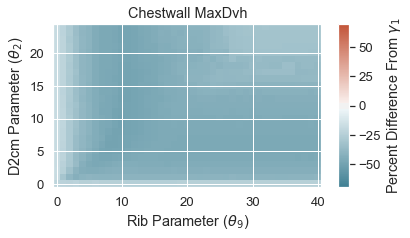

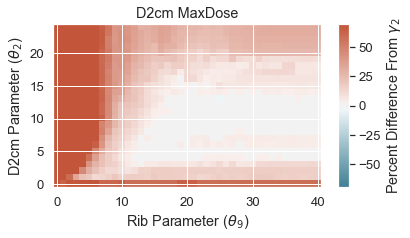

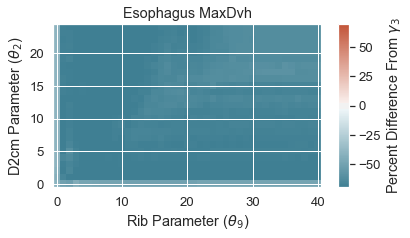

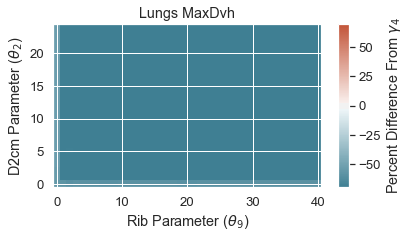

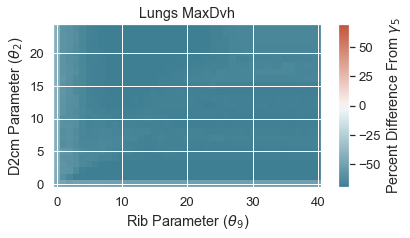

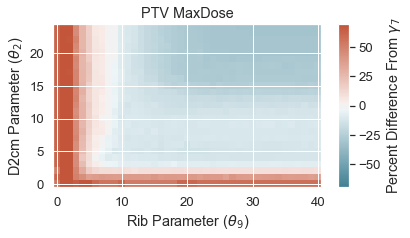

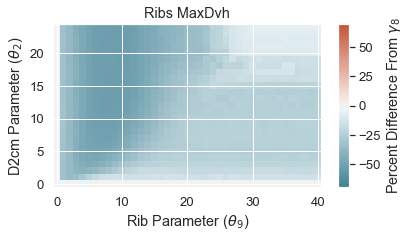

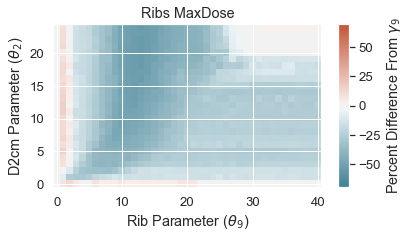

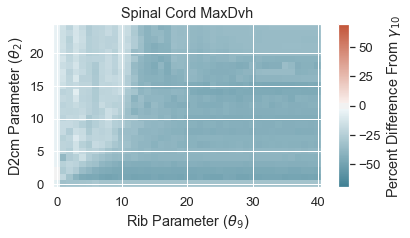

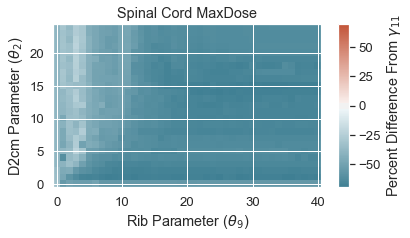

In [69]:
# Goal values vs. parameters (relative values)
labels = True
roi_names = ['Chestwall', 'D2cm', 'Esophagus', 'Lungs', 'Lungs', 'PTV', 'PTV', 'Ribs',
             'Ribs', 'Spinal Cord', 'Spinal Cord']
for goal in grid.goal_dict:
    if goal != 5:
        # Get percent difference from gamma
        k = 0
        Z = np.zeros((len(d2cm_grid), len(rib_grid)))
        for ii in range(len(d2cm_grid)):
            for jj in range(len(rib_grid)):
                gamma = grid.goal_df.iloc[goal]['AcceptanceLevel']
                Z[ii, jj] = 100*(grid.goal_dict[goal][k] - gamma)/gamma
                k += 1
        
        # Plot results
        plt.figure()
        dmax = np.max(np.abs(Z_goals))
        plt.imshow(Z, origin='lower', cmap=my_cmap, vmin=-dmax, vmax=dmax)
        cbar = plt.colorbar(shrink=0.75, aspect=15)
        if labels:
            plt.xlabel('Rib Parameter ($\\theta_9$)')
            plt.ylabel('D2cm Parameter ($\\theta_2$)')
            plt.title(f"{roi_names[goal]} {grid.goal_df.iloc[goal]['Type']}")
            if goal == 9:
                cbar.ax.set_ylabel('Percent Difference From $\\gamma_{10}$')
            elif goal == 10:
                cbar.ax.set_ylabel('Percent Difference From $\\gamma_{11}$')
            else:
                cbar.ax.set_ylabel(f'Percent Difference From $\\gamma_{goal + 1}$')
        else:
            plt.xticks(ticks=np.arange(0, 41, 10), labels=[])
            plt.yticks(ticks=np.arange(0, 21, 5), labels=[])
            cbar.ax.set_yticklabels([])
                
        # Save figures
        if goal < 5:
            plt.savefig(f"fig2{chr(goal + 97)}.png", bbox_inches='tight', dpi=300)
        else:
            plt.savefig(f"fig2{chr(goal + 96)}.png", bbox_inches='tight', dpi=300)

In [50]:
def plotGrid(bayes, title=None, cmin=False, labels=True):
    # Format parameter vectors
    d2cm_bayes = [row[0]/100 for row in bayes.opt_result.x_iters]
    rib_bayes = [row[1]/100 for row in bayes.opt_result.x_iters]
    
    # Plot samples on grid
    k = 0
    Z = np.zeros((len(d2cm_grid), len(rib_grid)))
    for ii in range(len(d2cm_grid)):
        for jj in range(len(rib_grid)):
            for index, row in bayes.goal_df.iterrows():
                Z[ii, jj] += raybay.get_term(grid.goal_dict[index][k], row['AcceptanceLevel'],
                                             row['Type'], row['Shape'])
            k += 1
    plt.imshow(Z, origin='lower')
    plt.plot(rib_dummy[:10], d2cm_dummy[:10], 'o', color=colors[4])
    plt.plot(rib_dummy[10:], d2cm_dummy[10:], '.', color=colors[4])
    plt.plot(rib_bayes, d2cm_bayes, '.', color=colors[2])
    
    # Plot optimal values
    idx_grid = np.unravel_index(np.argmax(Z), Z.shape)
    plt.plot(idx_grid[0], idx_grid[1], '*', color=colors[1], markersize=10, markeredgecolor='black')
    dummy_util = raybay.get_utility(bayes.goal_df, dummy.goal_dict)
    idx_dummy = np.argmax(dummy_util)
    plt.plot(rib_dummy[idx_dummy], d2cm_dummy[idx_dummy], '*', color=colors[4], markersize=10,
             markeredgecolor='black')
    plt.plot(bayes.opt_result.x[1]/100, bayes.opt_result.x[0]/100, '*', color=colors[2], markersize=10,
             markeredgecolor='black')
    cbar = plt.colorbar(shrink=0.75, aspect=15)
    if cmin:
        plt.clim([0, np.max(Z)])

    # Labels
    if labels:
        plt.xlabel('Rib Parameter ($\\theta_9$)')
        plt.ylabel('D2cm MaxDose ($\\theta_2$)')
        plt.title(title)
    else:
        plt.xticks(ticks=np.arange(0, 41, 10), labels=[])
        plt.yticks(ticks=np.arange(0, 21, 5), labels=[])
        cbar.ax.set_yticklabels([])

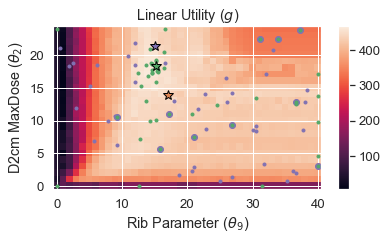

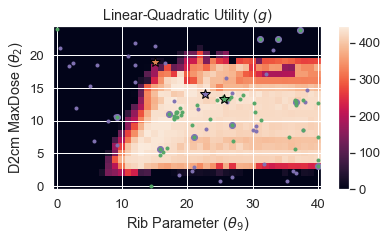

In [52]:
# Plot samples over utility landscape
plt.figure()
plotGrid(bayes_lin, 'Linear Utility ($g$)')
plt.savefig('fig3a.png', bbox_inches='tight', dpi=300)
plt.figure()
plotGrid(bayes_linquad, 'Linear-Quadratic Utility ($g$)', cmin=True)
plt.savefig('fig4a.png', bbox_inches='tight', dpi=300)

In [118]:
def plotConvergence(bayes, ylabel=None, ylim=False, labels=True):
    # Get grid values
    k = 0
    Z = np.zeros((len(d2cm_grid), len(rib_grid)))
    for ii in range(len(d2cm_grid)):
        for jj in range(len(rib_grid)):
            for index, row in bayes.goal_df.iterrows():
                Z[ii, jj] += raybay.get_term(grid.goal_dict[index][k], row['AcceptanceLevel'],
                                             row['Type'], row['Shape'])
            k += 1
    
    # Plot convergence
    plt.figure()
    plt.plot([0, 50], [np.max(Z), np.max(Z)], ':', color=colors[1])
    dummy_util = raybay.get_utility(bayes.goal_df, dummy.goal_dict)
    plt.plot(np.arange(1, 51), np.maximum.accumulate(dummy_util), color=colors[4])
    plt.plot(np.arange(1, 51), -np.minimum.accumulate(bayes.opt_result.func_vals), color=colors[2])
    if ylim:
        plt.ylim([0.9*np.max(Z), 1.01*np.max(Z)])
    if labels:
        plt.xlabel('Iteration ($t$)')
        plt.ylabel(ylabel)
        plt.legend(['Grid', 'Random', 'Bayes'])
    else:
        plt.xticks(np.arange(0, 51, 10), labels=[])
        plt.yticks(ticks=plt.yticks()[0], labels=[])
        plt.legend(['', '', ''], frameon=False)

<Figure size 432x288 with 0 Axes>

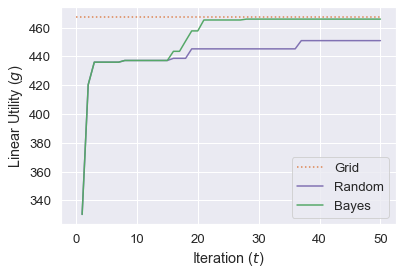

<Figure size 432x288 with 0 Axes>

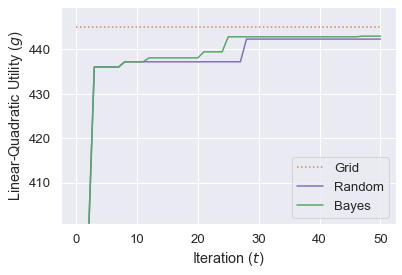

In [120]:
# Plot convergence
plt.figure()
plotConvergence(bayes_lin, 'Linear Utility ($g$)')
plt.savefig('fig3b.png', bbox_inches='tight', dpi=300)
plt.figure()
plotConvergence(bayes_linquad, 'Linear-Quadratic Utility ($g$)', ylim=True)
plt.savefig('fig4b.png', bbox_inches='tight', dpi=300)

In [67]:
def plotMean(bayes, cmin=False, labels=True):
    # Format parameter vectors
    d2cm_bayes = [row[0]/100 for row in bayes.opt_result.x_iters]
    rib_bayes = [row[1]/100 for row in bayes.opt_result.x_iters]
    
    # Plot samples on grid
    k = 0
    Z = np.zeros((len(d2cm_grid), len(rib_grid)))
    for ii in range(len(d2cm_grid)):
        for jj in range(len(rib_grid)):
            for index, row in bayes.goal_df.iterrows():
                grid_points = np.array([d2cm_grid[ii]/2400, rib_grid[jj]/4000]).reshape(1, -1)
                y_mean = bayes.opt_result.models[-1].predict(grid_points)
                Z[ii, jj] = -y_mean
            k += 1
    plt.imshow(Z, origin='lower')
    plt.plot(rib_bayes, d2cm_bayes, '.', color=colors[2])
    
    # Plot optimal values
    plt.plot(bayes.opt_result.x[1]/100, bayes.opt_result.x[0]/100, '*', color=colors[2], markersize=10,
             markeredgecolor='black')
    cbar = plt.colorbar(shrink=0.75, aspect=15)
    if cmin:
        plt.clim([0, np.max(Z)])

    # Labels
    if labels:
        plt.xlabel('Rib Parameter ($\\theta_9$)')
        plt.ylabel('D2cm MaxDose ($\\theta_2$)')
        plt.title('Bayes Posterior Mean')
    else:
        plt.xticks(ticks=np.arange(0, 41, 10), labels=[])
        plt.yticks(ticks=np.arange(0, 21, 5), labels=[])
        cbar.ax.set_yticklabels([])

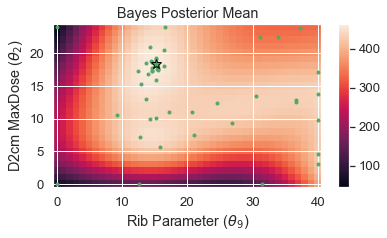

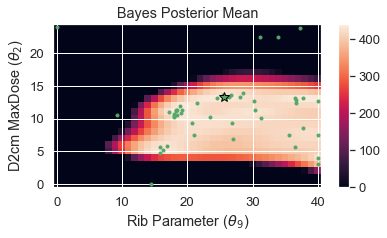

In [72]:
# Plot samples over surrogate mean
plt.figure()
plotMean(bayes_lin)
plt.savefig('fig3c.png', bbox_inches='tight', dpi=300)
plt.figure()
plotMean(bayes_linquad, cmin=True)`b
plt.savefig('fig4c.png', bbox_inches='tight', dpi=300)

In [77]:
def plotStdev(bayes, cmin=False, labels=True):
    # Format parameter vectors
    d2cm_bayes = [row[0]/100 for row in bayes.opt_result.x_iters]
    rib_bayes = [row[1]/100 for row in bayes.opt_result.x_iters]
    
    # Plot samples on grid
    k = 0
    Z = np.zeros((len(d2cm_grid), len(rib_grid)))
    for ii in range(len(d2cm_grid)):
        for jj in range(len(rib_grid)):
            for index, row in bayes.goal_df.iterrows():
                grid_points = np.array([d2cm_grid[ii]/2400, rib_grid[jj]/4000]).reshape(1, -1)
                _, y_std = bayes.opt_result.models[-1].predict(grid_points, return_std=True)
                Z[ii, jj] = y_std
            k += 1
    plt.imshow(Z, origin='lower')
    plt.plot(rib_bayes, d2cm_bayes, '.', color=colors[2])
    
    # Plot optimal values
    plt.plot(bayes.opt_result.x[1]/100, bayes.opt_result.x[0]/100, '*', color=colors[2], markersize=10,
             markeredgecolor='white')
    cbar = plt.colorbar(shrink=0.75, aspect=15)
    if cmin:
        plt.clim([0, np.max(Z)])

    # Labels
    if labels:
        plt.xlabel('Rib Parameter ($\\theta_9$)')
        plt.ylabel('D2cm MaxDose ($\\theta_2$)')
        plt.title('Bayes Posterior Standard Deviation')
    else:
        plt.xticks(ticks=np.arange(0, 41, 10), labels=[])
        plt.yticks(ticks=np.arange(0, 21, 5), labels=[])
        cbar.ax.set_yticklabels([])

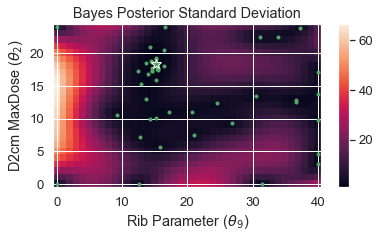

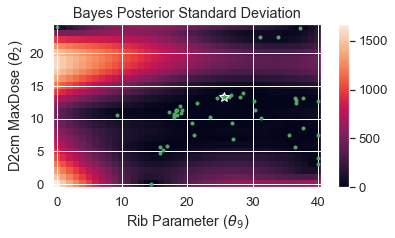

In [121]:
# Plot samples over surrogate mean
plt.figure()
plotStdev(bayes_lin)
plt.savefig('fig3d.png', bbox_inches='tight', dpi=300)
plt.figure()
plotStdev(bayes_linquad, cmin=True)
plt.savefig('fig4d.png', bbox_inches='tight', dpi=300)

In [116]:
np.unravel_index(np.argmax(Z.T), Z.T.shape)

(17, 14)

In [120]:
temp = 0
for index, row in bayes.goal_df.iterrows():
     temp += raybay.get_term(grid.goal_dict[index][711], row['AcceptanceLevel'], row['Type'], row['Shape'])

In [121]:
temp

467.58120777089823

In [130]:
roi_names

['Chestwall',
 'D2cm',
 'Esophagus',
 'Lungs',
 'Lungs',
 'PTV',
 'PTV',
 'Ribs',
 'Ribs',
 'Spinal Cord',
 'Spinal Cord']

In [133]:
roi_dict

{'Chestwall MaxDvh': 1,
 'D2cm MaxDose': 2,
 'Esophagus MaxDvh': 3,
 'Lungs MaxDvh': 5,
 'PTV MaxDose': 7,
 'Ribs MaxDvh': 8,
 'Ribs MaxDose': 9,
 'Spinal Cord MaxDvh': 10,
 'Spinal Cord MaxDose': 11}

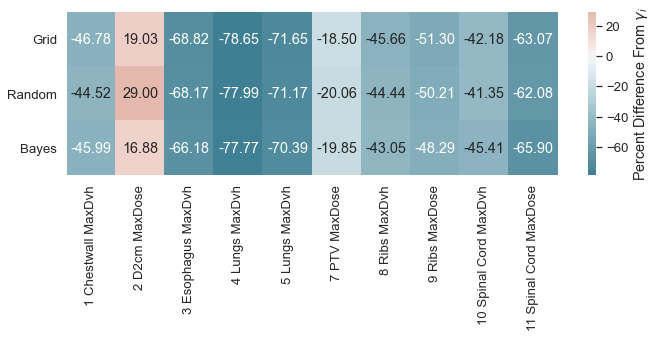

In [137]:
val_list = []
roi_dict = {}

res_list = [
    [grid, dummy, bayes],
]

for index, row in bayes.goal_df.iterrows():
    goal_vals = []
    
    if index != 5:
        roi_dict[f"{index + 1} {roi_names[index]} {row['Type']}"] = index + 1
        
        for res in res_list:
            idx_dummy = np.argmin(res[1].opt_result.func_vals)
            idx_bayes = np.argmin(res[2].opt_result.func_vals)
            level = res[2].goal_df.iloc[index]['AcceptanceLevel']
            val = res[0].goal_dict[index][711]
            goal_vals.append(100*(val - level)/level)
            val = res[1].goal_dict[index][idx_dummy]
            goal_vals.append(100*(val - level)/level)
            val = res[2].goal_dict[index][idx_bayes]
            goal_vals.append(100*(val - level)/level)

        val_list.append(goal_vals)
        
columns = ['Grid', 'Random', 'Bayes']
val_df = pd.DataFrame(columns=columns, data=val_list, index=roi_dict)
ncols = len(columns)
fig, ax = plt.subplots(1, figsize=(len(bayes.goal_df), ncols))
sns.heatmap(val_df.transpose(), cmap=sns.diverging_palette(220, 20, n=256), center=0,
            annot=True, fmt=".2f", cbar_kws={'label': 'Percent Difference From $\gamma_i$'}, ax=ax)
plt.yticks(rotation='horizontal')
#plt.savefig('toyLinGoals_labels.png', bbox_inches='tight', dpi=300)

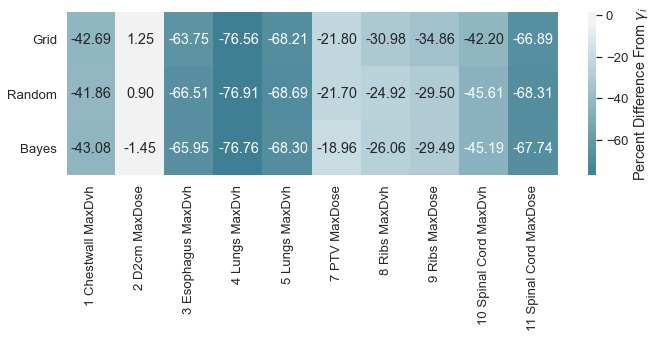

In [157]:
val_list = []
roi_dict = {}

res_list = [
    [grid, dummy, bayes],
]

for index, row in bayes.goal_df.iterrows():
    goal_vals = []
    
    if index != 5:
        roi_dict[f"{index + 1} {roi_names[index]} {row['Type']}"] = index + 1
        
        for res in res_list:
            idx_dummy = np.argmax(dummy_util)
            idx_bayes = np.argmin(res[2].opt_result.func_vals)
            level = res[2].goal_df.iloc[index]['AcceptanceLevel']
            val = res[0].goal_dict[index][634]
            goal_vals.append(100*(val - level)/level)
            val = res[1].goal_dict[index][idx_dummy]
            goal_vals.append(100*(val - level)/level)
            val = res[2].goal_dict[index][idx_bayes]
            goal_vals.append(100*(val - level)/level)

        val_list.append(goal_vals)
        
columns = ['Grid', 'Random', 'Bayes']
val_df = pd.DataFrame(columns=columns, data=val_list, index=roi_dict)
ncols = len(columns)
fig, ax = plt.subplots(1, figsize=(len(bayes.goal_df), ncols))
sns.heatmap(val_df.transpose(), cmap=sns.diverging_palette(220, 20, n=256), center=0,
            annot=True, fmt=".2f", cbar_kws={'label': 'Percent Difference From $\gamma_i$'}, ax=ax)
plt.yticks(rotation='horizontal')
#plt.savefig('toyLinQuadGoals_labels.png', bbox_inches='tight', dpi=300)